In [2]:
import numpy as np
import pandas as pd
from scipy.special import logit,expit
import collections
import matplotlib.pyplot as plt

In [3]:
data=pd.read_csv('wage.csv').drop(['Unnamed: 0','region','logwage','maritl'],axis=1)
X=data.drop(['wage'],axis=1)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        3000 non-null   int64  
 1   age         3000 non-null   int64  
 2   race        3000 non-null   object 
 3   education   3000 non-null   object 
 4   jobclass    3000 non-null   object 
 5   health      3000 non-null   object 
 6   health_ins  3000 non-null   object 
 7   wage        3000 non-null   float64
dtypes: float64(1), int64(2), object(5)
memory usage: 187.6+ KB


In [5]:
data['health'].value_counts()

2. >=Very Good    2142
1. <=Good          858
Name: health, dtype: int64

In [6]:
maprace={'1. White':1,'2. Black':2,'3. Asian':3,'4. Other':4}
maphealth_ins={'1. Yes':1,'2. No':2}
mapeducation={'1. < HS Grad':1,'2. HS Grad':2,'3. Some College':3,'4. College Grad':4,'5. Advanced Degree':5}
mapjobclass={'1. Industrial':1,'2. Information':2}
maphealth={'1. <=Good':1,'2. >=Very Good':2}

In [7]:
X['race']=data['race'].map(maprace)
X['health_ins']=data['health_ins'].map(maphealth_ins)
X['education']=data['education'].map(mapeducation)
X['jobclass']=data['jobclass'].map(mapjobclass)
X['health']=data['health'].map(maphealth)

In [8]:
X.insert(0,'num',1)

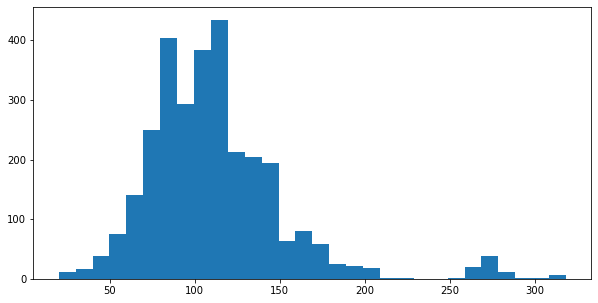

In [9]:
plt.figure(figsize=(10, 5))
plt.hist(data['wage'],bins=30)
plt.show()

In [10]:
Y=np.zeros(3000)
Y[np.where(data['wage']>=250)]=1

In [11]:
X.insert(8,'Y',Y)

In [13]:
X.to_csv('wagedata.csv',index=0)

In [14]:
X.head()

,num,year,age,race,education,jobclass,health,health_ins,Y
0,1,2006,18,1,1,1,1,2,0.0
1,1,2004,24,1,4,2,2,2,0.0
2,1,2003,45,1,3,1,1,1,0.0
3,1,2003,43,3,4,2,2,1,0.0
4,1,2005,50,1,2,2,1,1,0.0


In [ ]:
def g(x,y):
    y=np.dot(x,y)
    return y

def f(x,y):
    y=np.dot(x,y)
    return y

def pi(x,y):
    y=expit(g(x,y))
    return y

def phi(x,y):
    y=expit(f(x,y))
    return y

def I0(y):
    if y==0:
        return 1

In [ ]:
#E-step
def Lih(X,beta):
    Ga=np.zeros((N,2))

    for i in range(N):#响应度
        if Y[i]==1:
            Ga[i,0]=0
            Ga[i,1]=1
        elif Y[i]==0:
            a=(expit(np.dot(X[i],beta[0])))
            b=(1-a)*(1-expit(np.dot(X[i],beta[1])))
            Ga[i,0]=a/(a+b)
            Ga[i,1]=1-Ga[i,0]

    return Ga

In [ ]:
#M-step
def Q(X,Y,beta):
    Ga=Lih(X,beta)
    A=np.zeros(N)
    for i in range(N):
        pi=expit(np.dot(beta[0],X[i]))
        phi=expit(np.dot(beta[1],X[i]))
        if Y[i]==0:
            A[i]=(Ga[i,0])*np.log(pi)+(Ga[i,1])*np.log((1-pi)*(1-phi))
            #A[i]=Ga[i,0]*np.log(pi)+Ga[i,1]*np.log((1-pi)*(1-phi))
            #A[i]=(Ga[i,0]*np.log(pi))+(Ga[i,1]*(np.log(1-pi)+np.log(1-phi)))
        else:
            A[i]=(Ga[i,1])*np.log((1-pi)*(phi))
            #A[i]=Ga[i,0]*np.log(pi)+Ga[i,1]*np.log((1-pi)*(1-phi))
            #A[i]=(Ga[i,0]*np.log(pi))+(Ga[i,1]*(np.log(1-pi)+np.log(phi)))
        #A[i]=(Ga[i,0]*(1-Y[i])*np.log(pi))+(Ga[i,1]*(np.log(1-pi)+np.log(1-phi)+Y[i]*np.dot(X[i],beta[1])))
    Q=np.sum(A)
    return Q

def grad(X,Y,Ga,beta):
    A=np.zeros((N,P))
    B=np.zeros((N,P))
    for i in range(N):
        A[i]=((Ga[i,0]*(1-Y[i]))*(1-expit(np.dot(beta[0],X[i])))-(Ga[i,1]*expit(np.dot(beta[0],X[i]))))*X[i]
        B[i]=(Ga[i,1]*(Y[i]-expit(np.dot(beta[1],X[i]))))*X[i]
    grad1=np.sum(A,axis=0)
    grad2=np.sum(B,axis=0)
    grad=np.array([grad1,grad2])
    return grad



In [ ]:
def dgra(X,Y,ibeta,n=1000,t=0.01,xim=0.6,yim=0.3,zim=0.000001):#梯度下降（回溯梯度下降法）
    
    L=Lih(X,ibeta)#E-step
    for i in range(n):#M-step
        lik1=Q(X,Y,ibeta)
        ibeta=ibeta+t*grad(X,Y,L,ibeta)
        lik=Q(X,Y,ibeta)
        d=np.r_[ibeta[0],ibeta[1]]
        c=np.dot(d,d)
        b=(lik-lik1)
        if b>=yim*t*c:
            t=xim*t
        if c<=zim:
            break
    return ibeta